# Feature Engineering

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 10
PARAMS = dict(
    n_estimators = 300,
    random_state = RANDOM_SEED, 
    n_jobs = -1
)

In [2]:
import numpy as np
import pandas as pd
import time
import math
import pyarrow
import gc

# scikit-learn optimization
from sklearnex import patch_sklearn
patch_sklearn()

# Model evaluation
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier

# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Scoring Function

In [3]:
def score_model(sklearn_model, preprocessing = None):
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, target_bins)):
        
        # Training and Validation Sets
        X_train, y_train = train[features].iloc[train_idx], train['target'].iloc[train_idx]
        X_valid, y_valid = train[features].iloc[valid_idx], train['target'].iloc[valid_idx]
        train_weight, valid_weight = train['sample_weight'].iloc[train_idx], train['sample_weight'].iloc[valid_idx]
    
        # Preprocessing
        start = time.time()
        if preprocessing:
            X_train = preprocessing.fit_transform(X_train)
            X_valid = preprocessing.transform(X_valid)
        
        # Create model
        model = clone(sklearn_model)
        try:
            model.fit(X_train, y_train, sample_weight = train_weight)
        except:
            model.fit(X_train, y_train)
        
        # validation
        valid_preds = model.predict(X_valid)
        scores[fold] = accuracy_score(y_valid, valid_preds, sample_weight = valid_weight)
        oof_preds[valid_idx] = valid_preds.flatten()
        end = time.time()
        print(f'Fold {fold}: {round(scores[fold], 5)} accuracy in {round(end-start,2)}s.')
        times[fold] = end-start
        
    mask1, mask10 = train.gcd == 1, train.gcd == 10 
    mask1000, mask10000 = train.gcd == 1000, train.gcd == 10000
    print("\nAccuracy (1M Reads):", round(accuracy_score(oof_preds[mask1], train['target'].loc[mask1], sample_weight = train['sample_weight'].loc[mask1]), 5))
    print("Accuracy (100k Reads):", round(accuracy_score(oof_preds[mask10], train['target'].loc[mask10], sample_weight = train['sample_weight'].loc[mask10]), 5))
    print("Accuracy (1k Reads):", round(accuracy_score(oof_preds[mask1000], train['target'].loc[mask1000], sample_weight = train['sample_weight'].loc[mask1000]), 5))
    print("Accuracy (100 Reads):", round(accuracy_score(oof_preds[mask10000], train['target'].loc[mask10000], sample_weight = train['sample_weight'].loc[mask10000]), 5))
    print("Out-of-Fold Accuracy:", round(accuracy_score(oof_preds, train['target'], sample_weight = train['sample_weight']), 5))
    print(f'Training Time: {round(times.sum(), 2)}s')
    
    return oof_preds

# Scoring Function

In [4]:
# Scoring/Training Baseline Function
def score_model(sklearn_model, preprocessing = None):
    
    # Store the holdout predictions
    features = [x for x in train.columns if x not in ['row_id','target','sample_weight','gcd']]
    oof_preds = np.zeros((train.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, target_bins)):
        
        # Training and Validation Sets
        X_train, y_train = train[features].iloc[train_idx], train['target'].iloc[train_idx]
        X_valid, y_valid = train[features].iloc[valid_idx], train['target'].iloc[valid_idx]
        train_weight, valid_weight = train['sample_weight'].iloc[train_idx], train['sample_weight'].iloc[valid_idx]
    
        # Preprocessing
        start = time.time()
        if preprocessing:
            X_train = preprocessing.fit_transform(X_train)
            X_valid = preprocessing.transform(X_valid)
        
        # Create model
        model = clone(sklearn_model)
        model.fit(X_train, y_train, sample_weight = train_weight)
        
        # validation
        valid_preds = model.predict(X_valid)
        scores[fold] = accuracy_score(y_valid, valid_preds, sample_weight = valid_weight)
        oof_preds[valid_idx] = valid_preds.flatten()
        end = time.time()
        print(f'Fold {fold}: {round(scores[fold], 5)} accuracy in {round(end-start,2)}s.')
        times[fold] = end-start
        
    mask1, mask10 = train.gcd == 1, train.gcd == 10 
    mask1000, mask10000 = train.gcd == 1000, train.gcd == 10000
    print("\nAccuracy (1M Reads):", round(accuracy_score(oof_preds[mask1], train['target'].loc[mask1], sample_weight = train['sample_weight'].loc[mask1]), 5))
    print("Accuracy (100k Reads):", round(accuracy_score(oof_preds[mask10], train['target'].loc[mask10], sample_weight = train['sample_weight'].loc[mask10]), 5))
    print("Accuracy (1k Reads):", round(accuracy_score(oof_preds[mask1000], train['target'].loc[mask1000], sample_weight = train['sample_weight'].loc[mask1000]), 5))
    print("Accuracy (100 Reads):", round(accuracy_score(oof_preds[mask10000], train['target'].loc[mask10000], sample_weight = train['sample_weight'].loc[mask10000]), 5))
    print("Out-of-Fold Accuracy:", round(accuracy_score(oof_preds, train['target'], sample_weight = train['sample_weight']), 5))
    print(f'Training Time: {round(times.sum(), 2)}s')
    
    return oof_preds

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from math import factorial

def bias_of(column):
    w = int(column[1:column.index('T')])
    x = int(column[column.index('T')+1:column.index('G')])
    y = int(column[column.index('G')+1:column.index('C')])
    z = int(column[column.index('C')+1:])
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)


# Plot confusion matrix
def plot_confusion_matrix(true_values, pred_values, gcds, plot_title = "Confusion Matrix"):
    
    gcd = [[1,10],[1000,10000]]
    
    # Confusion matrix
    fig, ax = plt.subplots(2, 2, figsize = (12,9))
    for row in range(2):
        for col in range(2):
            idx = 2*row + col
            cm = confusion_matrix(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]])
            np.fill_diagonal(cm, 0)
            disp = ConfusionMatrixDisplay(confusion_matrix = cm)
            disp.plot(ax = ax[row,col])
    plt.show()

# Load Data

In [6]:
%%time
from sklearn.preprocessing import LabelEncoder

def load_data():
    train = pd.read_feather('../data/train.feather')
    features = [x for x in train.columns if x not in ['row_id','target','sample_weight','gcd']]

    encoder = LabelEncoder()
    train['target'] = encoder.fit_transform(train['target'])
    return train, encoder, features

train, encoder, features = load_data()
target_bins = train['target'].astype(str) + train['gcd'].astype(str)

print(f'Training Samples: {len(train)}')

Training Samples: 123993
CPU times: total: 1.05 s
Wall time: 201 ms


# Baseline


Fold 0: 0.96186 accuracy in 20.61s.
Fold 1: 0.95302 accuracy in 21.14s.
Fold 2: 0.9533 accuracy in 20.93s.
Fold 3: 0.95518 accuracy in 20.89s.
Fold 4: 0.95491 accuracy in 20.77s.
Fold 5: 0.95589 accuracy in 20.89s.
Fold 6: 0.95218 accuracy in 20.79s.
Fold 7: 0.95325 accuracy in 20.69s.
Fold 8: 0.95578 accuracy in 21.1s.
Fold 9: 0.95742 accuracy in 20.89s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 1.0
Accuracy (1k Reads): 0.91971
Accuracy (100 Reads): 0.90146
Out-of-Fold Accuracy: 0.95528
Training Time: 208.7s


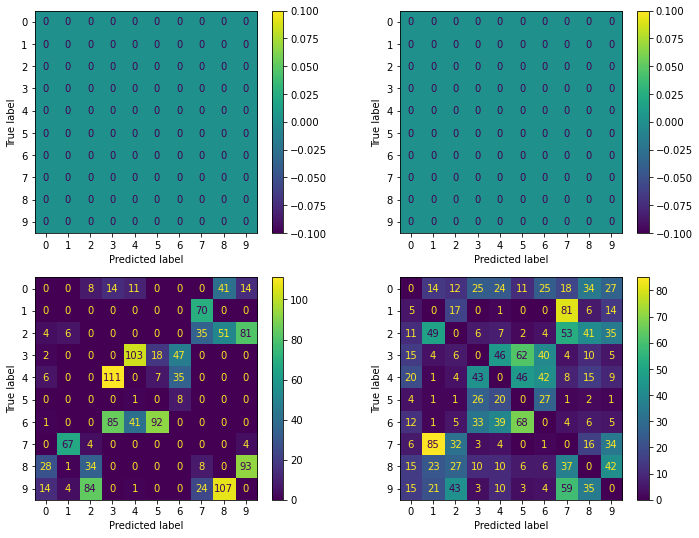

In [7]:
oof_preds = score_model(ExtraTreesClassifier(**PARAMS))

plot_confusion_matrix(train['target'],oof_preds, train['gcd'])

# Dual Features

We create an implicit graph structure by mapping each histogram into 4D space and connecting histograms which differ by one edit. Our new features will be the edge weights given by subtracting connected histograms based on their lexographical ordering.

In [8]:
from itertools import combinations

def neighbors(x,y):
    return np.sum(np.abs(x-y)) == 2

def embed_4d(column):
    w = int(column[1:column.index('T')])
    x = int(column[column.index('T')+1:column.index('G')])
    y = int(column[column.index('G')+1:column.index('C')])
    z = int(column[column.index('C')+1:])
    return np.array([w, x, y, z])

def flow_features(input_df):
    embeddings = {x:embed_4d(x) for x in features}
    for col1 in features:
        for col2 in features:
            x = embeddings[col1]
            y = embeddings[col2]
            input_df[col1 + '_flow'] = 0
            if neighbors(x,y):
                input_df[col1 + '_flow'] += input_df[col1] - input_df[col2]
    new_cols = [x for x in input_df.columns if x not in features]
    print('Number of new columns:', len(new_cols))
    return input_df 

Number of new columns: 289

Fold 0: 0.95937 accuracy in 26.88s.
Fold 1: 0.95127 accuracy in 26.84s.
Fold 2: 0.95456 accuracy in 26.95s.
Fold 3: 0.95884 accuracy in 27.05s.
Fold 4: 0.95571 accuracy in 26.91s.
Fold 5: 0.95658 accuracy in 26.79s.
Fold 6: 0.95248 accuracy in 26.84s.
Fold 7: 0.9547 accuracy in 26.87s.
Fold 8: 0.959 accuracy in 26.77s.
Fold 9: 0.95687 accuracy in 26.89s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 1.0
Accuracy (1k Reads): 0.91905
Accuracy (100 Reads): 0.90478
Out-of-Fold Accuracy: 0.95595
Training Time: 268.79s


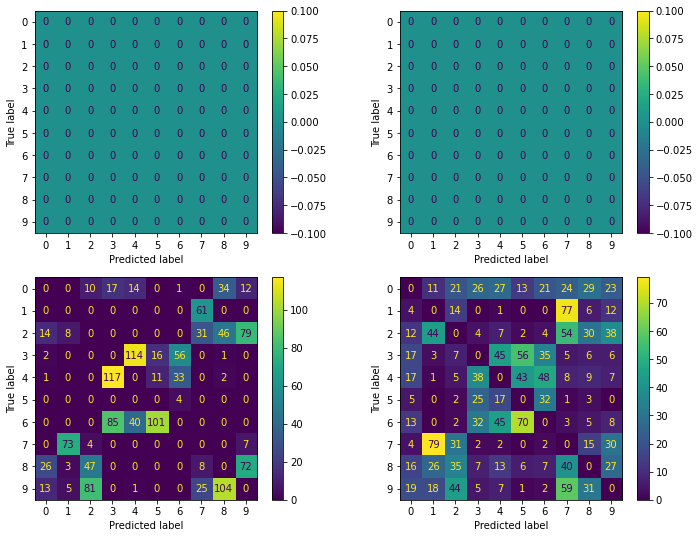

In [9]:
train, encoder, features = load_data()
train = flow_features(train)

oof_preds = score_model(ExtraTreesClassifier(**PARAMS))
plot_confusion_matrix(train['target'], oof_preds, train['gcd'])

# Raw Histograms

In [10]:
def get_histograms(input_df):
    return pd.DataFrame({
        col: ((input_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in features
    })

def get_raw_histograms(input_df):
    temp = get_histograms(input_df)
    for col in features:
        temp[col] //= input_df['gcd']
    return temp



Fold 0: 0.95723 accuracy in 18.27s.
Fold 1: 0.95312 accuracy in 18.22s.
Fold 2: 0.95658 accuracy in 18.3s.
Fold 3: 0.9576 accuracy in 18.27s.
Fold 4: 0.95771 accuracy in 18.21s.
Fold 5: 0.95853 accuracy in 18.3s.
Fold 6: 0.95698 accuracy in 18.24s.
Fold 7: 0.95465 accuracy in 18.15s.
Fold 8: 0.9531 accuracy in 18.2s.
Fold 9: 0.95526 accuracy in 18.16s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 1.0
Accuracy (1k Reads): 0.92123
Accuracy (100 Reads): 0.9031
Out-of-Fold Accuracy: 0.95608
Training Time: 182.34s


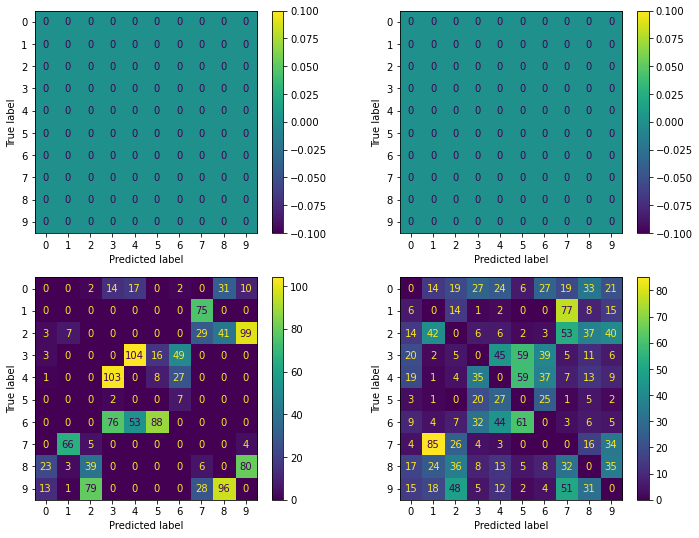

In [11]:
train, encoder, features = load_data()
train[features] = get_raw_histograms(train)

oof_preds = score_model(ExtraTreesClassifier(**PARAMS))
plot_confusion_matrix(train['target'], oof_preds, train['gcd'])

# Zero Count


Fold 0: 0.95977 accuracy in 20.82s.
Fold 1: 0.95342 accuracy in 20.88s.
Fold 2: 0.95365 accuracy in 20.88s.
Fold 3: 0.95627 accuracy in 21.01s.
Fold 4: 0.95596 accuracy in 21.05s.
Fold 5: 0.95953 accuracy in 20.9s.
Fold 6: 0.95415 accuracy in 20.99s.
Fold 7: 0.95495 accuracy in 20.83s.
Fold 8: 0.95657 accuracy in 20.89s.
Fold 9: 0.95918 accuracy in 20.91s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 0.99998
Accuracy (1k Reads): 0.92231
Accuracy (100 Reads): 0.90314
Out-of-Fold Accuracy: 0.95635
Training Time: 209.17s


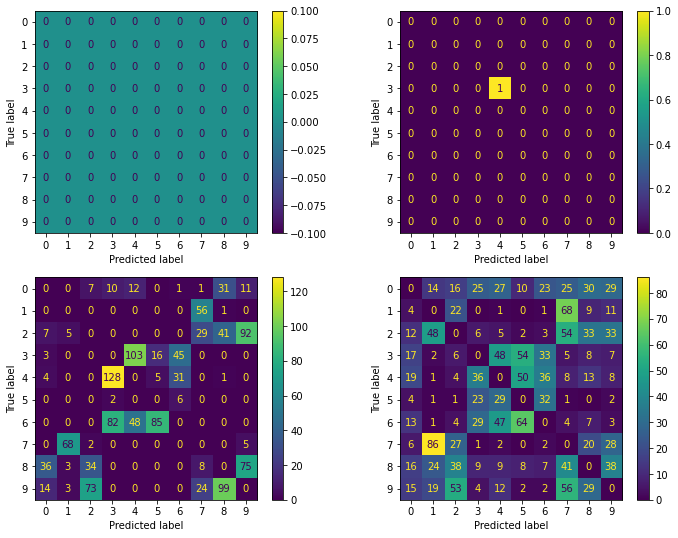

In [12]:
train, encoder, features = load_data()
train['zeros'] = (get_raw_histograms(train)[features] == 0).sum(axis = 1)

oof_preds = score_model(ExtraTreesClassifier(**PARAMS))
plot_confusion_matrix(train['target'], oof_preds, train['gcd'])